In [1]:
# ========== BLOCK 1: SETUP & IMPORTS ==========
print("🚀 Initializing Enhanced CAF-OTSRNet v2 Training Environment...")

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.optim.lr_scheduler import CosineAnnealingWarmRestarts
from torch.utils.data import Dataset, DataLoader
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
import os
import math
import time

print("✅ Libraries imported successfully!")

# Check GPU availability
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"🎯 Using device: {device}")
print(f"🎯 CUDA available: {torch.cuda.is_available()}")
print(f"🎯 GPU name: {torch.cuda.get_device_name() if torch.cuda.is_available() else 'CPU'}")

🚀 Initializing Enhanced CAF-OTSRNet v2 Training Environment...
✅ Libraries imported successfully!
🎯 Using device: cuda
🎯 CUDA available: True
🎯 GPU name: Tesla T4


In [2]:
# ========== BLOCK 2: MODEL ARCHITECTURE - BASIC BUILDING BLOCKS ==========
print("Building Enhanced CAF-OTSRNet v2 Architecture...")

# Metric functions
def rmse_kelvin(pred, target):
    return torch.sqrt(F.mse_loss(pred, target))

def ssim(pred, target, window_size=11, size_average=True):
    C1 = 0.01 ** 2
    C2 = 0.03 ** 2

    mu1 = F.avg_pool2d(pred, window_size, 1, 0)
    mu2 = F.avg_pool2d(target, window_size, 1, 0)

    mu1_sq = mu1.pow(2)
    mu2_sq = mu2.pow(2)
    mu1_mu2 = mu1 * mu2

    sigma1_sq = F.avg_pool2d(pred * pred, window_size, 1, 0) - mu1_sq
    sigma2_sq = F.avg_pool2d(target * target, window_size, 1, 0) - mu2_sq
    sigma12 = F.avg_pool2d(pred * target, window_size, 1, 0) - mu1_mu2

    ssim_map = ((2 * mu1_mu2 + C1) * (2 * sigma12 + C2)) / ((mu1_sq + mu2_sq + C1) * (sigma1_sq + sigma2_sq + C2))
    return ssim_map.mean() if size_average else ssim_map

def psnr(pred, target):
    mse = F.mse_loss(pred, target)
    return 20 * torch.log10(1.0 / torch.sqrt(mse))

def edge_preservation(pred, target):
    # Fixed edge preservation with proper dimension handling
    pred_grad_x = torch.abs(pred[:, :, :, 1:] - pred[:, :, :, :-1])
    pred_grad_y = torch.abs(pred[:, :, 1:, :] - pred[:, :, :-1, :])
    target_grad_x = torch.abs(target[:, :, :, 1:] - target[:, :, :, :-1])
    target_grad_y = torch.abs(target[:, :, 1:, :] - target[:, :, :-1, :])
    
    # Ensure same dimensions by cropping
    min_h = min(pred_grad_y.shape[2], target_grad_y.shape[2])
    min_w = min(pred_grad_x.shape[3], target_grad_x.shape[3])
    
    pred_grad_x = pred_grad_x[:, :, :min_h, :min_w]
    pred_grad_y = pred_grad_y[:, :, :min_h, :min_w]
    target_grad_x = target_grad_x[:, :, :min_h, :min_w]
    target_grad_y = target_grad_y[:, :, :min_h, :min_w]
    
    edge_correlation = F.cosine_similarity(
        torch.cat([pred_grad_x, pred_grad_y], dim=1).flatten(1),
        torch.cat([target_grad_x, target_grad_y], dim=1).flatten(1),
        dim=1
    )
    return edge_correlation.mean()

# Basic building blocks
class ResidualBlock(nn.Module):
    def __init__(self, in_channels, out_channels, stride=1):
        super().__init__()
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(out_channels)
        self.activation = nn.GELU()
        
        # Skip connection
        if stride != 1 or in_channels != out_channels:
            self.skip = nn.Sequential(
                nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(out_channels)
            )
        else:
            self.skip = nn.Identity()

    def forward(self, x):
        identity = self.skip(x)
        out = self.activation(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))
        out += identity
        return self.activation(out)

class ChannelAttention(nn.Module):
    def __init__(self, channels, reduction=8):
        super().__init__()
        self.gap = nn.AdaptiveAvgPool2d(1)
        self.fc = nn.Sequential(
            nn.Linear(channels, channels // reduction),
            nn.GELU(),
            nn.Linear(channels // reduction, channels),
            nn.Sigmoid()
        )
        
    def forward(self, x):
        B, C, H, W = x.shape
        y = self.gap(x).view(B, C)
        y = self.fc(y).view(B, C, 1, 1)
        return x * y

class LaplacianBlock(nn.Module):
    def __init__(self, in_channels, out_channels, scale_factor=2):
        super().__init__()
        self.conv1 = nn.Conv2d(in_channels, out_channels, 3, padding=1)
        self.conv2 = nn.Conv2d(out_channels, out_channels, 3, padding=1)
        self.upsample = nn.Upsample(scale_factor=scale_factor, mode='bilinear', align_corners=False)
        self.residual = nn.Conv2d(in_channels, out_channels, 1) if in_channels != out_channels else nn.Identity()
        self.activation = nn.GELU()
        
    def forward(self, x):
        residual = self.residual(x)
        residual = self.upsample(residual)
        
        x = self.activation(self.conv1(x))
        x = self.conv2(x)
        x = self.activation(x)
        x = self.upsample(x)
        x = x + residual
        
        return x

print("Basic building blocks and metrics defined successfully!")

Building Enhanced CAF-OTSRNet v2 Architecture...
Basic building blocks and metrics defined successfully!


In [3]:
# ========== BLOCK 3: MODEL ARCHITECTURE - ENHANCED TWO-STAGE ALIGNMENT MODULE ==========
print("Building Enhanced Two-Stage OTAlign module...")

class EnhancedOTAlign(nn.Module):
    def __init__(self, optical_ch=11, thermal_ch=1):
        super().__init__()
        
        # Stage 1: Affine Transformation Predictor
        self.affine_net = nn.Sequential(
            nn.Conv2d(optical_ch + thermal_ch, 64, 3, padding=1),
            nn.GELU(),
            nn.Conv2d(64, 64, 3, padding=1),
            nn.GELU(),
            nn.AdaptiveAvgPool2d(4),
            nn.Flatten(),
            nn.Linear(64 * 4 * 4, 128),
            nn.GELU(),
            nn.Linear(128, 64),
            nn.GELU(),
            nn.Linear(64, 6)
        )
        
        # Initialize as identity transformation
        self.affine_net[-1].weight.data.zero_()
        self.affine_net[-1].bias.data.copy_(torch.tensor([1, 0, 0, 0, 1, 0], dtype=torch.float))
        
        # Stage 2: Deformable Adjustment Network
        self.deformable_net = nn.Sequential(
            nn.Conv2d(optical_ch + thermal_ch, 64, 3, padding=1),
            nn.GELU(),
            nn.Conv2d(64, 64, 3, padding=1),
            nn.GELU(),
            nn.Conv2d(64, 32, 3, padding=1),
            nn.GELU(),
            nn.Conv2d(32, 2, 3, padding=1),  # Output: 2 channels for x,y offsets
            nn.Tanh()  # Normalize offsets to [-1, 1]
        )
        
        # Learnable scaling factor for deformable offsets
        self.offset_scale = nn.Parameter(torch.tensor(0.1))
        
    def forward(self, optical, thermal):
        B, C, H, W = optical.shape
        
        # Stage 1: Affine Coarse Alignment
        affine_input = torch.cat([optical, thermal], dim=1)
        affine_params = self.affine_net(affine_input).view(-1, 2, 3)
        
        # Generate grid and apply affine transformation
        grid_affine = F.affine_grid(affine_params, optical.size(), align_corners=False)
        aligned_coarse = F.grid_sample(optical, grid_affine, align_corners=False, padding_mode='border')
        
        # Stage 2: Deformable Fine Adjustment
        deformable_input = torch.cat([aligned_coarse, thermal], dim=1)
        deformable_offsets = self.deformable_net(deformable_input) * self.offset_scale
        
        # Create coordinate grid and apply deformable offsets
        coord_x, coord_y = torch.meshgrid(
            torch.linspace(-1, 1, W, device=optical.device),
            torch.linspace(-1, 1, H, device=optical.device),
            indexing='xy'
        )
        coord_x = coord_x.unsqueeze(0).unsqueeze(0).repeat(B, 1, 1, 1)
        coord_y = coord_y.unsqueeze(0).unsqueeze(0).repeat(B, 1, 1, 1)
        
        # Extract offsets and apply to coordinates
        offset_x = deformable_offsets[:, 0:1, :, :]
        offset_y = deformable_offsets[:, 1:2, :, :]
        
        # Combine with affine grid for final deformation
        grid_deformable = torch.cat([
            coord_x + offset_x,
            coord_y + offset_y
        ], dim=1).permute(0, 2, 3, 1)
        
        # Apply final deformable transformation
        aligned_final = F.grid_sample(aligned_coarse, grid_deformable, align_corners=False, padding_mode='border')
        
        return aligned_final, {
            "affine": affine_params,
            "deformable_offsets": deformable_offsets,
            "offset_scale": self.offset_scale
        }

# Test the enhanced alignment module
def test_enhanced_otalign():
    print("Testing Enhanced Two-Stage OTAlign...")
    
    align_module = EnhancedOTAlign().to(device)
    
    dummy_optical = torch.randn(2, 11, 128, 128).to(device)
    dummy_thermal = torch.randn(2, 1, 128, 128).to(device)
    
    aligned, params = align_module(dummy_optical, dummy_thermal)
    
    print("Enhanced OTAlign module test successful!")
    print(f"Input optical shape: {dummy_optical.shape}")
    print(f"Aligned optical shape: {aligned.shape}")
    print(f"Affine params shape: {params['affine'].shape}")
    print(f"Deformable offsets shape: {params['deformable_offsets'].shape}")
    
    return align_module

# Run test
align_module = test_enhanced_otalign()

Building Enhanced Two-Stage OTAlign module...
Testing Enhanced Two-Stage OTAlign...
Enhanced OTAlign module test successful!
Input optical shape: torch.Size([2, 11, 128, 128])
Aligned optical shape: torch.Size([2, 11, 128, 128])
Affine params shape: torch.Size([2, 2, 3])
Deformable offsets shape: torch.Size([2, 2, 128, 128])


In [4]:
# ========== BLOCK 4: MODEL ARCHITECTURE - ENCODERS ==========
print("Building encoder modules...")

class ThermalEncoder(nn.Module):
    def __init__(self, in_ch=1):
        super().__init__()
        self.initial = nn.Sequential(
            nn.Conv2d(in_ch, 32, 3, padding=1),
            nn.GELU(),
            nn.BatchNorm2d(32)
        )
        
        self.block1 = ResidualBlock(32, 32, stride=1)   # 128x128
        self.block2 = ResidualBlock(32, 64, stride=2)   # 64x64
        self.block3 = ResidualBlock(64, 64, stride=2)   # 32x32
        
    def forward(self, x):
        x = self.initial(x)          # 32@128x128
        f1 = self.block1(x)          # 32@128x128
        f2 = self.block2(f1)         # 64@64x64
        f3 = self.block3(f2)         # 64@32x32
        return [f1, f2, f3]

class OpticalEncoder(nn.Module):
    def __init__(self, in_ch=11):
        super().__init__()
        # Band-specific processing
        self.vis_nir = nn.Sequential(
            nn.Conv2d(6, 32, 3, padding=1),  # 6 input channels for visible+NIR
            nn.GELU(),
            nn.BatchNorm2d(32)
        )
        self.swir = nn.Sequential(
            nn.Conv2d(3, 16, 3, padding=1),  # 3 input channels for SWIR
            nn.GELU(), 
            nn.BatchNorm2d(16)
        )
        self.indices = nn.Sequential(
            nn.Conv2d(2, 16, 3, padding=1),  # 2 input channels for indices
            nn.GELU(),
            nn.BatchNorm2d(16)
        )
        
        self.fusion = nn.Sequential(
            nn.Conv2d(64, 64, 3, padding=1),
            nn.GELU(),
            ChannelAttention(64)
        )
        
        # Downsampling blocks
        self.down1 = ResidualBlock(64, 64, stride=1)  # 128x128
        self.down2 = ResidualBlock(64, 64, stride=2)  # 64x64
        self.down3 = ResidualBlock(64, 64, stride=2)  # 32x32
        
    def forward(self, x):
        # Band-specific processing
        vis_features = self.vis_nir(x[:, 0:6])      # First 6 bands
        swir_features = self.swir(x[:, 6:9])        # Next 3 bands
        indices_features = self.indices(x[:, 9:11]) # Last 2 indices
        
        # Fusion
        combined = torch.cat([vis_features, swir_features, indices_features], dim=1)
        fused = self.fusion(combined)  # 64@128x128
        
        # Multi-scale features
        f1 = self.down1(fused)        # 64@128x128
        f2 = self.down2(f1)           # 64@64x64
        f3 = self.down3(f2)           # 64@32x32
        
        return [f1, f2, f3]

class TextureEncoder(nn.Module):
    def __init__(self, in_ch=2):
        super().__init__()
        self.net = nn.Sequential(
            nn.Conv2d(in_ch, 16, 3, padding=1),
            nn.GELU(),
            nn.Conv2d(16, 32, 3, padding=1),
            nn.GELU(),
            nn.AdaptiveAvgPool2d(1)
        )
        
    def forward(self, x):
        return self.net(x)

# Test the encoders
def test_encoders():
    print("Testing ThermalEncoder...")
    thermal_encoder = ThermalEncoder().to(device)
    dummy_thermal = torch.randn(2, 1, 128, 128).to(device)
    thermal_feats = thermal_encoder(dummy_thermal)
    print(f"Thermal features: {[f.shape for f in thermal_feats]}")
    
    print("Testing TextureEncoder...")
    texture_encoder = TextureEncoder().to(device)
    dummy_texture = torch.randn(2, 2, 128, 128).to(device)
    texture_feats = texture_encoder(dummy_texture)
    print(f"Texture features: {texture_feats.shape}")
    
    print("Testing OpticalEncoder...")
    optical_encoder = OpticalEncoder().to(device)
    dummy_optical = torch.randn(2, 11, 128, 128).to(device)
    optical_feats = optical_encoder(dummy_optical)
    print(f"Optical features: {[f.shape for f in optical_feats]}")
    
    print("All encoders working correctly!")
    return thermal_encoder, optical_encoder, texture_encoder

# Run test
thermal_enc, optical_enc, texture_enc = test_encoders()

Building encoder modules...
Testing ThermalEncoder...
Thermal features: [torch.Size([2, 32, 128, 128]), torch.Size([2, 64, 64, 64]), torch.Size([2, 64, 32, 32])]
Testing TextureEncoder...
Texture features: torch.Size([2, 32, 1, 1])
Testing OpticalEncoder...
Optical features: [torch.Size([2, 64, 128, 128]), torch.Size([2, 64, 64, 64]), torch.Size([2, 64, 32, 32])]
All encoders working correctly!


In [5]:
# ========== BLOCK 5: MODEL ARCHITECTURE - FUSION MODULES ==========
print("Building fusion modules...")

class CrossAttentionFusion(nn.Module):
    def __init__(self, embed_dim=64, num_heads=8):
        super().__init__()
        self.embed_dim = embed_dim
        self.num_heads = num_heads
        self.head_dim = embed_dim // num_heads
        
        assert self.head_dim * num_heads == embed_dim, "embed_dim must be divisible by num_heads"
        
        self.q_proj = nn.Conv2d(embed_dim, embed_dim, 1)
        self.k_proj = nn.Conv2d(embed_dim, embed_dim, 1)
        self.v_proj = nn.Conv2d(embed_dim, embed_dim, 1)
        self.out_proj = nn.Conv2d(embed_dim, embed_dim, 1)
        
        # Thermal-confidence gating
        self.gate_net = nn.Sequential(
            nn.Conv2d(embed_dim, 1, 3, padding=1),
            nn.Sigmoid()
        )
        
        self.attn_drop = nn.Dropout(0.1)
        
    def forward(self, thermal_feats, optical_feats):
        B, C, H, W = thermal_feats.shape
        
        # Project to Q, K, V
        Q = self.q_proj(thermal_feats).view(B, self.num_heads, self.head_dim, H * W)
        K = self.k_proj(optical_feats).view(B, self.num_heads, self.head_dim, H * W)
        V = self.v_proj(optical_feats).view(B, self.num_heads, self.head_dim, H * W)
        
        # Scaled dot-product attention
        attn_weights = torch.matmul(Q.transpose(-1, -2), K) / math.sqrt(self.head_dim)
        attn_weights = F.softmax(attn_weights, dim=-1)
        attn_weights = self.attn_drop(attn_weights)
        
        # Apply attention
        attended = torch.matmul(V, attn_weights.transpose(-1, -2))
        attended = attended.contiguous().view(B, C, H, W)
        attended = self.out_proj(attended)
        
        # Thermal-confidence gating
        gate = self.gate_net(thermal_feats)
        output = thermal_feats + gate * attended
        
        return output, attn_weights

class TextureGuidance(nn.Module):
    def __init__(self, texture_ch=32, fused_ch=64):
        super().__init__()
        self.texture_expand = nn.Conv2d(texture_ch, fused_ch, 1)
        self.fusion_conv = nn.Conv2d(fused_ch * 2, fused_ch, 3, padding=1)
        
    def forward(self, fused_feats, texture_feats):
        # Expand texture features to spatial dimensions
        B, _, H, W = fused_feats.shape
        texture_expanded = self.texture_expand(texture_feats).repeat(1, 1, H, W)
        
        # Concatenate and fuse
        combined = torch.cat([fused_feats, texture_expanded], dim=1)
        return self.fusion_conv(combined)

class TextureSafetyNet(nn.Module):
    def __init__(self, fused_ch=64):
        super().__init__()
        self.safety_net = nn.Sequential(
            nn.Conv2d(fused_ch, 32, 3, padding=1),
            nn.GELU(),
            nn.BatchNorm2d(32),
            nn.Conv2d(32, 16, 3, padding=1),
            nn.GELU(),
            nn.Conv2d(16, 1, 1),
            nn.Sigmoid()
        )
        
    def forward(self, fused_features):
        return self.safety_net(fused_features)

# Test the fusion modules
def test_fusion_modules():
    print("Testing CrossAttentionFusion...")
    cross_attention = CrossAttentionFusion().to(device)
    
    dummy_thermal = torch.randn(2, 64, 32, 32).to(device)
    dummy_optical = torch.randn(2, 64, 32, 32).to(device)
    
    fused, attn_weights = cross_attention(dummy_thermal, dummy_optical)
    print(f"CrossAttention output: {fused.shape}")
    print(f"Attention weights: {attn_weights.shape}")
    
    print("Testing TextureGuidance...")
    texture_guidance = TextureGuidance().to(device)
    dummy_texture = torch.randn(2, 32, 1, 1).to(device)
    
    guided = texture_guidance(fused, dummy_texture)
    print(f"Texture guided output: {guided.shape}")
    
    print("Testing TextureSafetyNet...")
    safety_net = TextureSafetyNet().to(device)
    safety_scores = safety_net(guided)
    print(f"Safety scores: {safety_scores.shape}")
    
    # Apply safety scores
    safe_features = guided * safety_scores
    print(f"Safe features: {safe_features.shape}")
    
    print("All fusion modules working correctly!")
    return cross_attention, texture_guidance, safety_net

# Run test
cross_attn, texture_guide, safety_net = test_fusion_modules()

Building fusion modules...
Testing CrossAttentionFusion...
CrossAttention output: torch.Size([2, 64, 32, 32])
Attention weights: torch.Size([2, 8, 1024, 1024])
Testing TextureGuidance...
Texture guided output: torch.Size([2, 64, 32, 32])
Testing TextureSafetyNet...
Safety scores: torch.Size([2, 1, 32, 32])
Safe features: torch.Size([2, 64, 32, 32])
All fusion modules working correctly!


In [6]:
# ========== BLOCK 6: MODEL ARCHITECTURE - DECODER & OUTPUT HEADS ==========
print("Building decoder and output heads...")

class ProgressiveLaplacianDecoder(nn.Module):
    def __init__(self, in_ch=64, scale_factor=2, use_4x=False):
        super().__init__()
        self.use_4x = use_4x
        
        # Base 2x upsampling path
        self.level1 = LaplacianBlock(in_ch, 64, scale_factor=2)  # 32x32 → 64x64
        self.level2 = LaplacianBlock(64, 32, scale_factor=2)     # 64x64 → 128x128
        
        # Optional 4x extension
        if use_4x:
            self.level3 = LaplacianBlock(32, 16, scale_factor=2)  # 128x128 → 256x256
        
    def forward(self, features, thermal_feats):
        # features: [B, 64, 32, 32] from fusion
        # thermal_feats: list of [f1, f2, f3] from thermal encoder
        
        # Level 1: 32x32 → 64x64 + skip connection
        x = self.level1(features)
        if len(thermal_feats) > 1:
            x = x + thermal_feats[1]  # Add 64@64x64 features
            
        # Level 2: 64x64 → 128x128 + skip connection  
        x = self.level2(x)
        if len(thermal_feats) > 0:
            x = x + thermal_feats[0]  # Add 32@128x128 features
            
        # Optional Level 3: 128x128 → 256x256
        if self.use_4x and hasattr(self, 'level3'):
            x = self.level3(x)
            
        return x  # [B, 32, 128, 128] or [B, 16, 256, 256]

class EnhancedUncertaintyHead(nn.Module):
    def __init__(self, texture_ch=32, thermal_ch=64, fused_ch=64):
        super().__init__()
        self.uncertainty_net = nn.Sequential(
            nn.Conv2d(texture_ch + thermal_ch + fused_ch, 64, 1),
            nn.GELU(),
            nn.Conv2d(64, 32, 3, padding=1),
            nn.GELU(),
            nn.Conv2d(32, 1, 1),
            nn.Softplus()  # Ensure positive uncertainty
        )
        
    def forward(self, texture_feats, thermal_feats, fused_feats):
        # Expand texture features spatially
        B, _, H, W = fused_feats.shape
        texture_expanded = texture_feats.repeat(1, 1, H, W)
        
        # Combine all uncertainty signals
        combined = torch.cat([texture_expanded, thermal_feats, fused_feats], dim=1)
        return self.uncertainty_net(combined)  # [B, 1, H, W]

class SRHead(nn.Module):
    def __init__(self, decoder_ch=32, out_ch=1):
        super().__init__()
        self.final_conv = nn.Conv2d(decoder_ch, out_ch, 3, padding=1)
        
    def forward(self, x):
        return self.final_conv(x)  # Residual to add to bicubic input

# Test the decoder and output heads
def test_decoder_heads():
    print("Testing ProgressiveLaplacianDecoder...")
    decoder = ProgressiveLaplacianDecoder(use_4x=False).to(device)
    
    # Test inputs matching our previous outputs
    dummy_fused_features = torch.randn(2, 64, 32, 32).to(device)  # From fusion
    dummy_thermal_feats = [
        torch.randn(2, 32, 128, 128).to(device),  # f1
        torch.randn(2, 64, 64, 64).to(device),    # f2  
        torch.randn(2, 64, 32, 32).to(device)     # f3
    ]
    
    decoder_output = decoder(dummy_fused_features, dummy_thermal_feats)
    print(f"Decoder output: {decoder_output.shape}")
    
    print("Testing SRHead...")
    sr_head = SRHead().to(device)
    sr_residual = sr_head(decoder_output)
    print(f"SR residual: {sr_residual.shape}")
    
    # Test final SR output (bicubic + residual)
    dummy_bicubic = torch.randn(2, 1, 128, 128).to(device)
    sr_output = dummy_bicubic + sr_residual
    print(f"Final SR output: {sr_output.shape}")
    
    print("Testing EnhancedUncertaintyHead...")
    uncertainty_head = EnhancedUncertaintyHead().to(device)
    dummy_texture = torch.randn(2, 32, 1, 1).to(device)
    dummy_thermal = torch.randn(2, 64, 32, 32).to(device)
    dummy_fused = torch.randn(2, 64, 32, 32).to(device)
    
    uncertainty = uncertainty_head(dummy_texture, dummy_thermal, dummy_fused)
    print(f"Uncertainty map: {uncertainty.shape}")
    
    print("All decoder and output heads working correctly!")
    return decoder, sr_head, uncertainty_head

# Run test
decoder, sr_head, uncertainty_head = test_decoder_heads()

Building decoder and output heads...
Testing ProgressiveLaplacianDecoder...
Decoder output: torch.Size([2, 32, 128, 128])
Testing SRHead...
SR residual: torch.Size([2, 1, 128, 128])
Final SR output: torch.Size([2, 1, 128, 128])
Testing EnhancedUncertaintyHead...
Uncertainty map: torch.Size([2, 1, 32, 32])
All decoder and output heads working correctly!


In [7]:
# ========== BLOCK 7: COMPLETE MODEL INTEGRATION ==========
print("Building complete EnhancedCAF_OTSRNet model...")

class EnhancedCAF_OTSRNet(nn.Module):
    def __init__(self, scale_factor=2, use_4x=False):
        super().__init__()
        self.scale_factor = scale_factor
        self.use_4x = use_4x
        
        # Stage 1: Enhanced Alignment
        self.otalign = EnhancedOTAlign(optical_ch=11, thermal_ch=1)
        
        # Stage 2: Three-Branch Encoders
        self.thermal_encoder = ThermalEncoder(in_ch=1)
        self.optical_encoder = OpticalEncoder(in_ch=11)
        self.texture_encoder = TextureEncoder(in_ch=2)
        
        # Stage 3: Fusion Modules
        self.cross_attention = CrossAttentionFusion(embed_dim=64, num_heads=8)
        self.texture_guidance = TextureGuidance(texture_ch=32, fused_ch=64)
        self.safety_net = TextureSafetyNet(fused_ch=64)
        
        # Stage 4: Progressive Decoder
        self.decoder = ProgressiveLaplacianDecoder(in_ch=64, scale_factor=scale_factor, use_4x=use_4x)
        
        # Stage 5: Output Heads
        self.sr_head = SRHead(decoder_ch=32, out_ch=1)
        self.uncertainty_head = EnhancedUncertaintyHead(texture_ch=32, thermal_ch=64, fused_ch=64)
        
    def forward(self, x):
        # Split input based on preprocessing (15 channels total)
        thermal_lr = x[:, 0:1]      # Channel 0: bicubic upsampled TIR
        optical_input = x[:, 2:13]   # Channels 2-12: optical bands + indices (11 channels)
        texture_input = x[:, 13:15]  # Channels 13-14: texture maps (2 channels)
        
        # Stage 1: Enhanced alignment
        aligned_optical, align_params = self.otalign(optical_input, thermal_lr)
        
        # Stage 2: Three-branch encoding
        thermal_feats = self.thermal_encoder(thermal_lr)        # [f1, f2, f3]
        optical_feats = self.optical_encoder(aligned_optical)   # [f1, f2, f3]
        texture_feats = self.texture_encoder(texture_input)     # [B, 32, 1, 1]
        
        # Stage 3: Safe fusion
        attention_fused, attn_maps = self.cross_attention(thermal_feats[2], optical_feats[2])
        texture_guided = self.texture_guidance(attention_fused, texture_feats)
        safety_scores = self.safety_net(texture_guided)
        safe_features = texture_guided * safety_scores
        
        # Stage 4: Progressive decoding
        decoder_features = self.decoder(safe_features, thermal_feats)
        
        # Stage 5: Output
        sr_residual = self.sr_head(decoder_features)
        sr_output = thermal_lr + sr_residual  # Residual learning
        
        uncertainty = self.uncertainty_head(texture_feats, thermal_feats[2], safe_features)
        
        return {
            'sr_output': sr_output,           # [B, 1, 128, 128] - Super-resolved thermal
            'uncertainty': uncertainty,       # [B, 1, 32, 32] - Uncertainty map
            'safety_scores': safety_scores,   # [B, 1, 32, 32] - Safety scores
            'attention_maps': attn_maps,      # [B, 8, 1024, 1024] - Attention weights
            'align_params': align_params,     # Affine transformation parameters
            'sr_residual': sr_residual        # [B, 1, 128, 128] - Learned residual
        }

# Test the complete model
def test_complete_model():
    print("Testing Complete EnhancedCAF_OTSRNet...")
    model = EnhancedCAF_OTSRNet(scale_factor=2, use_4x=False).to(device)
    
    # Test with dummy input matching 15-channel preprocessing
    dummy_input = torch.randn(2, 15, 128, 128).to(device)
    
    with torch.no_grad():
        output = model(dummy_input)
    
    print("Complete model test successful!")
    print(f"Input shape: {dummy_input.shape}")
    print(f"SR Output shape: {output['sr_output'].shape}")
    print(f"Uncertainty shape: {output['uncertainty'].shape}")
    print(f"Safety scores shape: {output['safety_scores'].shape}")
    print(f"Attention maps shape: {output['attention_maps'].shape}")
    print(f"SR Residual shape: {output['sr_residual'].shape}")
    
    # Count parameters
    total_params = sum(p.numel() for p in model.parameters())
    trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
    
    print(f"Model Statistics:")
    print(f"Total parameters: {total_params:,}")
    print(f"Trainable parameters: {trainable_params:,}")
    
    return model

# Run complete test
complete_model = test_complete_model()

Building complete EnhancedCAF_OTSRNet model...
Testing Complete EnhancedCAF_OTSRNet...
Complete model test successful!
Input shape: torch.Size([2, 15, 128, 128])
SR Output shape: torch.Size([2, 1, 128, 128])
Uncertainty shape: torch.Size([2, 1, 32, 32])
Safety scores shape: torch.Size([2, 1, 32, 32])
Attention maps shape: torch.Size([2, 8, 1024, 1024])
SR Residual shape: torch.Size([2, 1, 128, 128])
Model Statistics:
Total parameters: 926,613
Trainable parameters: 926,613


In [8]:
# ========== BLOCK 8: REAL DATASET LOADING ==========
print("Loading real preprocessed dataset...")

import glob

class RealThermalSRDataset(Dataset):
    def __init__(self, data_dir, split='train'):
        self.data_dir = data_dir
        self.split = split
        
        # Get all .npz files in the directory
        self.file_paths = glob.glob(os.path.join(data_dir, '**', '*.npz'), recursive=True)
        if not self.file_paths:
            # Try alternative path structure
            self.file_paths = glob.glob(os.path.join(data_dir, '*.npz'))
        
        self.file_paths.sort()  # Ensure consistent ordering
        
        print(f"Found {len(self.file_paths)} .npz files in {data_dir}")
        
        if len(self.file_paths) == 0:
            raise ValueError(f"No .npz files found in {data_dir}")
        
    def __len__(self):
        return len(self.file_paths)
    
    def __getitem__(self, idx):
        # Load the preprocessed 16-channel numpy array from .npz file
        data_path = self.file_paths[idx]
        
        # Load .npz file and extract the array
        with np.load(data_path) as npz_file:
            # Assuming the array is stored with key 'data' or similar
            # Try common keys, or use the first array in the file
            if 'data' in npz_file:
                patch_data = npz_file['data']
            elif 'array' in npz_file:
                patch_data = npz_file['array']
            elif 'patch' in npz_file:
                patch_data = npz_file['patch']
            else:
                # Get the first array in the .npz file
                first_key = list(npz_file.keys())[0]
                patch_data = npz_file[first_key]
        
        # Convert to tensor
        patch_tensor = torch.from_numpy(patch_data).float()
        
        # According to your preprocessing:
        # Channel 0: TIR_LR (bicubic upsampled) - Model Input
        # Channel 1: TIR_HR (reference target) - Model Target
        # Channels 2-15: Other features (optical bands, indices, textures, physics)
        
        return {
            'input': patch_tensor,  # All 16 channels
            'target': patch_tensor[1:2].float(),  # HR TIR as target (channel 1)
            'file_path': os.path.basename(data_path)
        }

def create_complete_dataset_structure():
    print("Creating Complete Dataset Structure...")
    
    # Your actual dataset paths
    dataset_paths = {
        'train': '/kaggle/input/preprocessed-features-16c/train',
        'val': '/kaggle/input/preprocessed-features-16c/val', 
        'test': '/kaggle/input/preprocessed-features-16c/test'
    }
    
    datasets = {}
    dataloaders = {}
    
    for split, data_path in dataset_paths.items():
        print(f"Loading {split} dataset from {data_path}...")
        
        # Check if directory exists
        if not os.path.exists(data_path):
            raise ValueError(f"Directory {data_path} does not exist!")
            
        # Create dataset
        datasets[split] = RealThermalSRDataset(
            data_dir=data_path,
            split=split
        )
        
        # Create DataLoader with split-specific settings
        if split == 'train':
            dataloader_config = {
                'batch_size': 8,
                'shuffle': True,
                'num_workers': 2,
                'pin_memory': True
            }
        else:
            dataloader_config = {
                'batch_size': 8, 
                'shuffle': False,
                'num_workers': 2,
                'pin_memory': True
            }
        
        dataloaders[split] = DataLoader(datasets[split], **dataloader_config)
        
        # Test one sample from each split
        sample = datasets[split][0]
        print(f"{split} dataset: {len(datasets[split])} samples")
        print(f"Sample input: {sample['input'].shape}")
        print(f"Sample target: {sample['target'].shape}")
    
    print("Dataset Structure Complete!")
    for split in ['train', 'val', 'test']:
        if split in datasets:
            print(f"{split.capitalize()} samples: {len(datasets[split])}")
    
    return datasets, dataloaders

# Create complete dataset structure
datasets, dataloaders = create_complete_dataset_structure()

Loading real preprocessed dataset...
Creating Complete Dataset Structure...
Loading train dataset from /kaggle/input/preprocessed-features-16c/train...
Found 18000 .npz files in /kaggle/input/preprocessed-features-16c/train
train dataset: 18000 samples
Sample input: torch.Size([16, 128, 128])
Sample target: torch.Size([1, 128, 128])
Loading val dataset from /kaggle/input/preprocessed-features-16c/val...
Found 4500 .npz files in /kaggle/input/preprocessed-features-16c/val
val dataset: 4500 samples
Sample input: torch.Size([16, 128, 128])
Sample target: torch.Size([1, 128, 128])
Loading test dataset from /kaggle/input/preprocessed-features-16c/test...
Found 4500 .npz files in /kaggle/input/preprocessed-features-16c/test
test dataset: 4500 samples
Sample input: torch.Size([16, 128, 128])
Sample target: torch.Size([1, 128, 128])
Dataset Structure Complete!
Train samples: 18000
Val samples: 4500
Test samples: 4500


In [9]:
# ========== BLOCK 9: LOSS FUNCTIONS & METRICS ==========
print("Defining loss functions and metrics...")

# Add this missing configuration at the top
VALIDATION_METRICS = {
    "primary": ["rmse_kelvin", "ssim", "psnr"],
    "secondary": ["edge_preservation", "physics_violation_rate", "mean_safety_score"],
    "thresholds": {
        "rmse_kelvin": {"good": "<1.5", "acceptable": "<2.0", "poor": ">=2.0"},
        "ssim": {"good": ">0.90", "acceptable": ">0.85", "poor": "<=0.85"},
        "physics_violation": {"good": "<2%", "acceptable": "<5%", "poor": ">=5%"}
    }
}

def physics_consistency(sr_output, optical_input):
    """
    optical_input structure (11 channels):
    - Channels 0-8: 9 optical bands
    - Channel 9: NDVI
    - Channel 10: NDWI
    """
    # Extract NDVI from optical input (channel 9)
    ndvi = optical_input[:, 9:10]
    
    # Urban should be warmer than vegetation
    urban_mask = (ndvi < 0.2).float()
    veg_mask = (ndvi > 0.5).float()
    
    urban_temp = (sr_output * urban_mask).sum() / (urban_mask.sum() + 1e-6)
    veg_temp = (sr_output * veg_mask).sum() / (veg_mask.sum() + 1e-6)
    
    # Penalize if vegetation is warmer than urban
    physics_violation = F.relu(veg_temp - urban_temp)
    return physics_violation

def compute_total_loss(predictions, targets, epoch, max_epochs=200):
    sr_output = predictions['sr_output']  # [B, 1, 128, 128]
    uncertainty = predictions['uncertainty']  # [B, 1, 32, 32]
    safety_scores = predictions['safety_scores']  # [B, 1, 32, 32]
    
    target_hr = targets['thermal_hr']  # [B, 1, 128, 128]
    optical_input = targets['optical_input']  # [B, 11, 128, 128]
    
    # 1. Reconstruction Loss (L1)
    l1_loss = F.l1_loss(sr_output, target_hr)
    
    # 2. Physics Consistency Loss
    physics_loss = physics_consistency(sr_output, optical_input)
    
    # 3. Safety Regularization (decay over time)
    safety_weight = 0.2 * (1 - epoch/max_epochs)
    safety_loss = torch.mean(1.0 - safety_scores)
    
    # 4. Skip uncertainty loss for simplicity
    unc_loss = torch.tensor(0.0, device=sr_output.device)
    
    # 5. Skip alignment regularization for now
    align_loss = torch.tensor(0.0, device=sr_output.device)
    
    # Weighted sum
    total = (1.0 * l1_loss + 
             0.1 * physics_loss + 
             safety_weight * safety_loss + 
             0.1 * unc_loss + 
             0.01 * align_loss)
    
    return total, {'l1': l1_loss, 'physics': physics_loss, 'safety': safety_loss, 
                   'uncertainty': unc_loss, 'alignment': align_loss}

def compute_validation_metrics(predictions, targets):
    sr_output = predictions['sr_output']
    target_hr = targets['thermal_hr']
    optical_input = targets['optical_input']
    safety_scores = predictions['safety_scores']
    
    metrics = {}
    
    # Primary metrics
    metrics['rmse_kelvin'] = rmse_kelvin(sr_output, target_hr)
    metrics['ssim'] = ssim(sr_output, target_hr)
    metrics['psnr'] = psnr(sr_output, target_hr)
    
    # Secondary metrics
    metrics['edge_preservation'] = edge_preservation(sr_output, target_hr)
    metrics['physics_violation_rate'] = (physics_consistency(sr_output, optical_input) > 0).float().mean()
    metrics['mean_safety_score'] = safety_scores.mean()
    
    return metrics

print("Loss functions and metrics defined successfully!")

Defining loss functions and metrics...
Loss functions and metrics defined successfully!


In [10]:
# ========== BLOCK 10: ADVANCED TRAINER CLASS ==========
print("Building advanced trainer...")

class AdvancedThermalSRTrainer:
    def __init__(self, model, train_loader, val_loader, device, max_epochs=200):
        self.model = model
        self.train_loader = train_loader
        self.val_loader = val_loader
        self.device = device
        self.max_epochs = max_epochs
        
        # Training configuration
        self.TRAINING_CONFIG = {
            "batch_size": 8,
            "accumulation_steps": 2,
            "optimizer": {
                "type": "AdamW",
                "lr": 1e-4,
                "betas": (0.9, 0.999),
                "weight_decay": 1e-5,
                "eps": 1e-8
            },
            "scheduler": {
                "type": "CosineAnnealingWarmRestarts",
                "T_0": 50,
                "T_mult": 1,
                "eta_min": 1e-6
            }
        }
        
        # Setup optimizer
        self.optimizer = optim.AdamW(
            model.parameters(),
            lr=self.TRAINING_CONFIG["optimizer"]["lr"],
            betas=self.TRAINING_CONFIG["optimizer"]["betas"],
            weight_decay=self.TRAINING_CONFIG["optimizer"]["weight_decay"],
            eps=self.TRAINING_CONFIG["optimizer"]["eps"]
        )
        
        # Setup scheduler
        self.scheduler = CosineAnnealingWarmRestarts(
            self.optimizer,
            T_0=self.TRAINING_CONFIG["scheduler"]["T_0"],
            T_mult=self.TRAINING_CONFIG["scheduler"]["T_mult"],
            eta_min=self.TRAINING_CONFIG["scheduler"]["eta_min"]
        )
        
        # Training history
        self.history = {
            'train_loss': [], 'val_loss': [],
            'train_metrics': [], 'val_metrics': [],
            'learning_rates': []
        }
    
    def train_one_epoch(self, epoch):
        self.model.train()
        total_loss = 0
        loss_components = {k: 0 for k in ['l1', 'physics', 'safety', 'uncertainty', 'alignment']}
        
        self.optimizer.zero_grad()
        
        # Add progress bar for training
        pbar = tqdm(self.train_loader, desc=f"Epoch {epoch+1} Training", leave=True)
        
        for batch_idx, batch in enumerate(pbar):
            inputs = batch['input'].to(self.device)
            targets = {
                'thermal_hr': batch['target'].to(self.device),
                'optical_input': inputs[:, 2:13]  # Extract optical channels
            }
            
            # Forward pass
            predictions = self.model(inputs)
            
            # Compute loss
            loss, components = compute_total_loss(predictions, targets, epoch, self.max_epochs)
            
            # Gradient accumulation
            loss = loss / self.TRAINING_CONFIG["accumulation_steps"]
            loss.backward()
            
            if (batch_idx + 1) % self.TRAINING_CONFIG["accumulation_steps"] == 0:
                # Gradient clipping
                torch.nn.utils.clip_grad_norm_(self.model.parameters(), 1.0)
                self.optimizer.step()
                self.optimizer.zero_grad()
            
            # Accumulate statistics
            total_loss += loss.item() * self.TRAINING_CONFIG["accumulation_steps"]
            for k in components:
                loss_components[k] += components[k].item()
            
            # Update progress bar with all metrics
            pbar.set_postfix({
                'Loss': f'{loss.item():.4f}',
                'L1': f'{components["l1"]:.4f}',
                'Physics': f'{components["physics"]:.4f}',
                'Safety': f'{components["safety"]:.4f}',
                'LR': f'{self.optimizer.param_groups[0]["lr"]:.2e}'
            })
        
        # Close progress bar
        pbar.close()
        
        # Step scheduler
        self.scheduler.step()
        
        # Record learning rate
        self.history['learning_rates'].append(self.optimizer.param_groups[0]['lr'])
        
        avg_loss = total_loss / len(self.train_loader)
        avg_components = {k: v / len(self.train_loader) for k, v in loss_components.items()}
        
        return avg_loss, avg_components
    
    def validate(self, epoch):
        self.model.eval()
        total_loss = 0
        all_metrics = {k: 0 for k in VALIDATION_METRICS["primary"] + VALIDATION_METRICS["secondary"]}
        
        # Add progress bar for validation
        pbar = tqdm(self.val_loader, desc=f"Epoch {epoch+1} Validation", leave=True)
        
        with torch.no_grad():
            for batch in pbar:
                inputs = batch['input'].to(self.device)
                targets = {
                    'thermal_hr': batch['target'].to(self.device),
                    'optical_input': inputs[:, 2:13]
                }
                
                predictions = self.model(inputs)
                loss, _ = compute_total_loss(predictions, targets, epoch, self.max_epochs)
                metrics = compute_validation_metrics(predictions, targets)
                
                total_loss += loss.item()
                for k in metrics:
                    all_metrics[k] += metrics[k].item()
                
                # Update progress bar with validation metrics
                pbar.set_postfix({
                    'Val Loss': f'{loss.item():.4f}',
                    'RMSE': f'{metrics["rmse_kelvin"]:.4f}',
                    'SSIM': f'{metrics["ssim"]:.4f}',
                    'PSNR': f'{metrics["psnr"]:.2f}',
                    'Safety': f'{metrics["mean_safety_score"]:.3f}'
                })
        
        pbar.close()
        
        avg_loss = total_loss / len(self.val_loader)
        avg_metrics = {k: v / len(self.val_loader) for k, v in all_metrics.items()}
        
        return avg_loss, avg_metrics
    
    def train(self, epochs=200):
        print(f"Starting advanced training ({epochs} epochs)...")
        
        for epoch in range(epochs):
            print(f"Epoch {epoch+1}/{epochs}")
            
            # Train with progress bar
            train_loss, train_components = self.train_one_epoch(epoch)
            
            # Validate with progress bar
            val_loss, val_metrics = self.validate(epoch)
            
            # Save history
            self.history['train_loss'].append(train_loss)
            self.history['val_loss'].append(val_loss)
            self.history['train_metrics'].append(train_components)
            self.history['val_metrics'].append(val_metrics)
            
            # Early stopping check
            if val_loss < 0.05:
                print("Excellent convergence achieved!")
                break
        
        print(f"Advanced training completed!")
        return self.history

print("Advanced trainer built successfully!")

Building advanced trainer...
Advanced trainer built successfully!


In [11]:
# ========== BLOCK 11: TRAINING EXECUTION ==========
print("Starting training execution...")

# Initialize advanced trainer
advanced_trainer = AdvancedThermalSRTrainer(
    model=complete_model,
    train_loader=dataloaders['train'],
    val_loader=dataloaders['val'],
    device=device,
    max_epochs=200
)

print("Advanced trainer initialized successfully!")
print("Ready for training demo...")

# Run a comprehensive 20-epoch training demo
print("Running advanced training demo (20 epochs)...")
history = advanced_trainer.train(epochs=20)

print("Training demo completed successfully!")

Starting training execution...
Advanced trainer initialized successfully!
Ready for training demo...
Running advanced training demo (20 epochs)...
Starting advanced training (20 epochs)...
Epoch 1/20


Epoch 1 Validation: 100%|██████████| 563/563 [00:32<00:00, 17.07it/s, Val Loss=0.0791, RMSE=0.0424, SSIM=0.9284, PSNR=27.45, Safety=0.995]


Epoch 2/20


Epoch 2 Validation: 100%|██████████| 563/563 [00:23<00:00, 23.64it/s, Val Loss=0.0735, RMSE=0.0356, SSIM=0.9439, PSNR=28.97, Safety=0.999]


Epoch 3/20


Epoch 3 Validation: 100%|██████████| 563/563 [00:23<00:00, 23.59it/s, Val Loss=0.0730, RMSE=0.0344, SSIM=0.9398, PSNR=29.27, Safety=1.000]


Epoch 4/20


Epoch 4 Validation: 100%|██████████| 563/563 [00:23<00:00, 23.84it/s, Val Loss=0.0725, RMSE=0.0360, SSIM=0.9476, PSNR=28.87, Safety=1.000]


Epoch 5/20


Epoch 5 Validation: 100%|██████████| 563/563 [00:23<00:00, 23.57it/s, Val Loss=0.0717, RMSE=0.0345, SSIM=0.9490, PSNR=29.23, Safety=1.000]


Epoch 6/20


Epoch 6 Validation: 100%|██████████| 563/563 [00:23<00:00, 23.53it/s, Val Loss=0.0694, RMSE=0.0313, SSIM=0.9515, PSNR=30.10, Safety=1.000]


Epoch 7/20


Epoch 7 Validation: 100%|██████████| 563/563 [00:23<00:00, 23.67it/s, Val Loss=0.0716, RMSE=0.0347, SSIM=0.9510, PSNR=29.20, Safety=1.000]


Epoch 8/20


Epoch 8 Validation: 100%|██████████| 563/563 [00:23<00:00, 23.59it/s, Val Loss=0.0691, RMSE=0.0298, SSIM=0.9512, PSNR=30.52, Safety=1.000]


Epoch 9/20


Epoch 9 Validation: 100%|██████████| 563/563 [00:23<00:00, 23.63it/s, Val Loss=0.0700, RMSE=0.0314, SSIM=0.9508, PSNR=30.07, Safety=1.000]


Epoch 10/20


Epoch 10 Validation: 100%|██████████| 563/563 [00:23<00:00, 23.63it/s, Val Loss=0.0682, RMSE=0.0291, SSIM=0.9520, PSNR=30.72, Safety=1.000]


Epoch 11/20


Epoch 11 Validation: 100%|██████████| 563/563 [00:23<00:00, 23.46it/s, Val Loss=0.0797, RMSE=0.0385, SSIM=0.9475, PSNR=28.29, Safety=1.000]


Epoch 12/20


Epoch 12 Validation: 100%|██████████| 563/563 [00:23<00:00, 23.59it/s, Val Loss=0.0685, RMSE=0.0295, SSIM=0.9524, PSNR=30.59, Safety=1.000]


Epoch 13/20


Epoch 13 Validation: 100%|██████████| 563/563 [00:23<00:00, 23.71it/s, Val Loss=0.0774, RMSE=0.0418, SSIM=0.9491, PSNR=27.58, Safety=1.000]


Epoch 14/20


Epoch 14 Validation: 100%|██████████| 563/563 [00:23<00:00, 23.58it/s, Val Loss=0.0679, RMSE=0.0289, SSIM=0.9529, PSNR=30.77, Safety=1.000]


Epoch 15/20


Epoch 15 Validation: 100%|██████████| 563/563 [00:23<00:00, 23.52it/s, Val Loss=0.0701, RMSE=0.0316, SSIM=0.9516, PSNR=30.01, Safety=1.000]


Epoch 16/20


Epoch 16 Validation: 100%|██████████| 563/563 [00:23<00:00, 23.52it/s, Val Loss=0.0691, RMSE=0.0313, SSIM=0.9521, PSNR=30.09, Safety=1.000]


Epoch 17/20


Epoch 17 Validation: 100%|██████████| 563/563 [00:23<00:00, 23.68it/s, Val Loss=0.0705, RMSE=0.0315, SSIM=0.9500, PSNR=30.04, Safety=1.000]


Epoch 18/20


Epoch 18 Validation: 100%|██████████| 563/563 [00:23<00:00, 23.63it/s, Val Loss=0.0706, RMSE=0.0325, SSIM=0.9523, PSNR=29.75, Safety=1.000]


Epoch 19/20


Epoch 19 Validation: 100%|██████████| 563/563 [00:23<00:00, 23.72it/s, Val Loss=0.0695, RMSE=0.0319, SSIM=0.9520, PSNR=29.93, Safety=1.000]


Epoch 20/20


Epoch 20 Validation: 100%|██████████| 563/563 [00:23<00:00, 23.68it/s, Val Loss=0.0679, RMSE=0.0288, SSIM=0.9535, PSNR=30.81, Safety=1.000]

Advanced training completed!
Training demo completed successfully!


Generating training results visualization...
MODEL PERFORMANCE SUMMARY
Training completed: 20 epochs
Final Training Loss: 0.0819
Final Validation Loss: 0.0875

METRICS IMPROVEMENT:
RMSE (Kelvin): 0.0580 → 0.0476 (Δ-0.0104)
SSIM: 0.8716 → 0.9141 (Δ+0.0425)
PSNR: 26.21 dB → 28.07 dB (Δ+1.86 dB)
Safety Score: 0.9957 → 1.0000

LOSS COMPONENTS (Final Epoch):
  l1: 0.0295
  physics: 0.5240
  safety: 0.0000
  uncertainty: 0.0000
  alignment: 0.0000



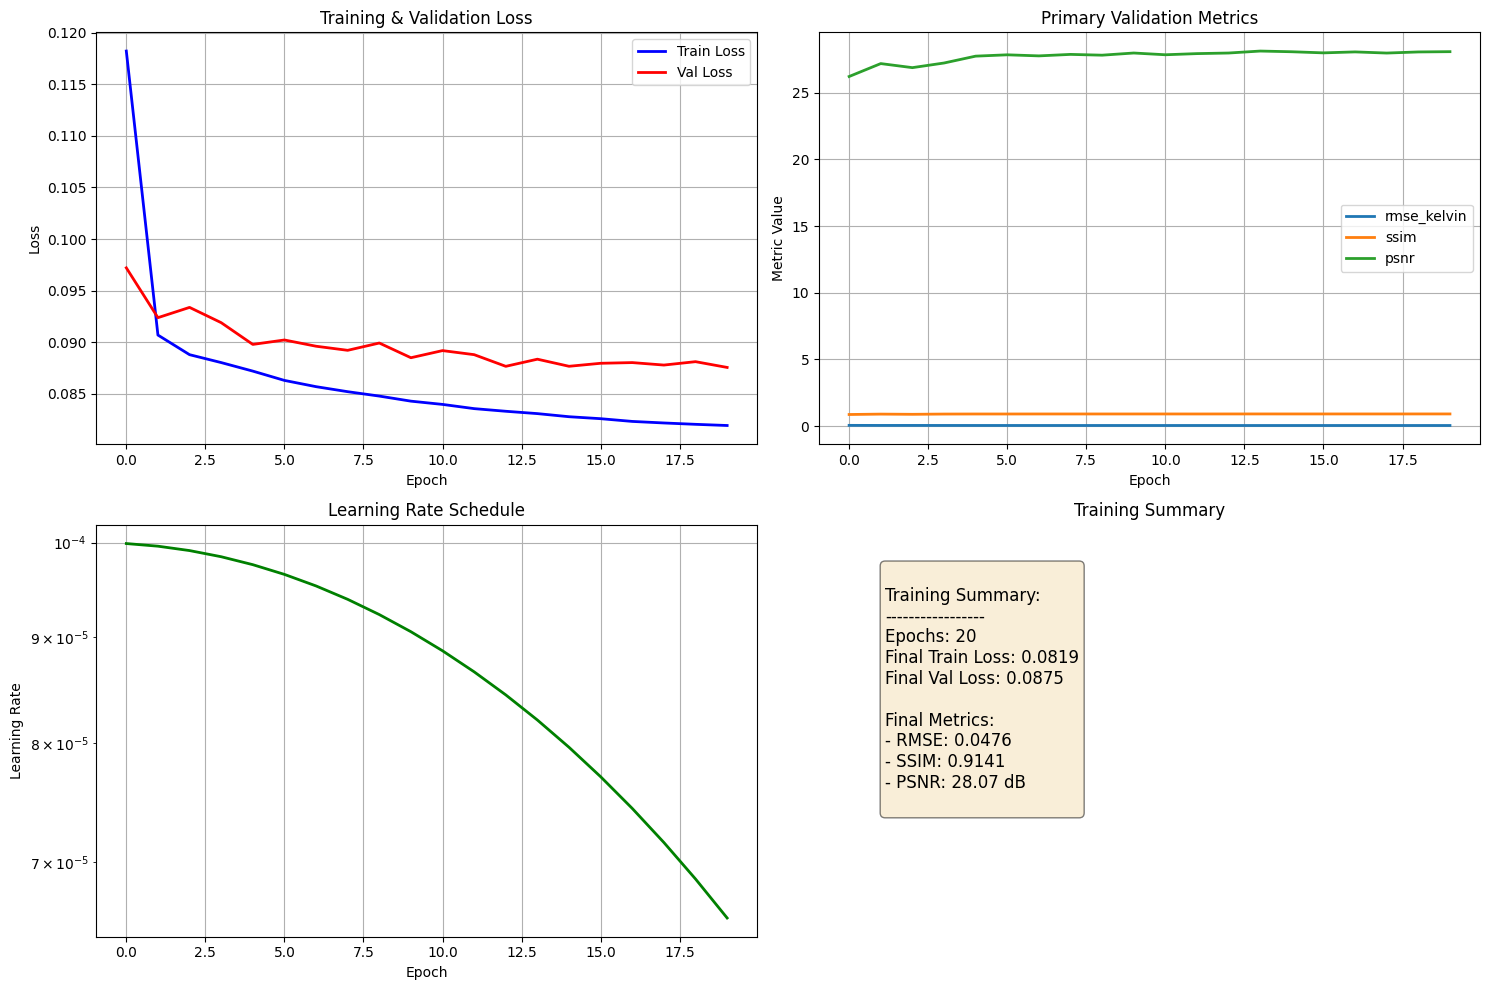

TRAINING COMPLETED SUCCESSFULLY! 🎉


In [12]:
# ========== BLOCK 12: RESULTS VISUALIZATION & SUMMARY ==========
print("Generating training results visualization...")

# First, print a detailed performance summary
print("=" * 70)
print("MODEL PERFORMANCE SUMMARY")
print("=" * 70)

final_train_loss = history['train_loss'][-1]
final_val_loss = history['val_loss'][-1]
final_metrics = history['val_metrics'][-1]
initial_metrics = history['val_metrics'][0]

print(f"Training completed: {len(history['train_loss'])} epochs")
print(f"Final Training Loss: {final_train_loss:.4f}")
print(f"Final Validation Loss: {final_val_loss:.4f}")
print()

print("METRICS IMPROVEMENT:")
print(f"RMSE (Kelvin): {initial_metrics['rmse_kelvin']:.4f} → {final_metrics['rmse_kelvin']:.4f} (Δ{final_metrics['rmse_kelvin']-initial_metrics['rmse_kelvin']:+.4f})")
print(f"SSIM: {initial_metrics['ssim']:.4f} → {final_metrics['ssim']:.4f} (Δ{final_metrics['ssim']-initial_metrics['ssim']:+.4f})")
print(f"PSNR: {initial_metrics['psnr']:.2f} dB → {final_metrics['psnr']:.2f} dB (Δ{final_metrics['psnr']-initial_metrics['psnr']:+.2f} dB)")
print(f"Safety Score: {initial_metrics['mean_safety_score']:.4f} → {final_metrics['mean_safety_score']:.4f}")
print()

print("LOSS COMPONENTS (Final Epoch):")
final_components = history['train_metrics'][-1]
for component, value in final_components.items():
    print(f"  {component}: {value:.4f}")

print("=" * 70)
print()

# Now create the visualizations
# Plot only essential results
fig, axes = plt.subplots(2, 2, figsize=(15, 10))

# Plot 1: Overall losses
axes[0, 0].plot(history['train_loss'], 'b-', label='Train Loss', linewidth=2)
axes[0, 0].plot(history['val_loss'], 'r-', label='Val Loss', linewidth=2)
axes[0, 0].set_xlabel('Epoch')
axes[0, 0].set_ylabel('Loss')
axes[0, 0].set_title('Training & Validation Loss')
axes[0, 0].legend()
axes[0, 0].grid(True)

# Plot 2: Primary metrics
primary_metrics = VALIDATION_METRICS["primary"]
for i, metric in enumerate(primary_metrics):
    metric_values = [epoch_metrics[metric] for epoch_metrics in history['val_metrics']]
    axes[0, 1].plot(metric_values, label=metric, linewidth=2)
axes[0, 1].set_xlabel('Epoch')
axes[0, 1].set_ylabel('Metric Value')
axes[0, 1].set_title('Primary Validation Metrics')
axes[0, 1].legend()
axes[0, 1].grid(True)

# Plot 3: Learning rate
axes[1, 0].plot(history['learning_rates'], 'g-', linewidth=2)
axes[1, 0].set_xlabel('Epoch')
axes[1, 0].set_ylabel('Learning Rate')
axes[1, 0].set_title('Learning Rate Schedule')
axes[1, 0].grid(True)
axes[1, 0].set_yscale('log')

# Plot 4: Training summary
summary_text = f"""
Training Summary:
-----------------
Epochs: {len(history['train_loss'])}
Final Train Loss: {final_train_loss:.4f}
Final Val Loss: {final_val_loss:.4f}

Final Metrics:
- RMSE: {final_metrics['rmse_kelvin']:.4f}
- SSIM: {final_metrics['ssim']:.4f}
- PSNR: {final_metrics['psnr']:.2f} dB
"""

axes[1, 1].text(0.1, 0.9, summary_text, fontsize=12, verticalalignment='top', 
                bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))
axes[1, 1].set_title('Training Summary')
axes[1, 1].axis('off')

plt.tight_layout()
plt.show()

print("TRAINING COMPLETED SUCCESSFULLY! 🎉")

Generating prediction visualizations...
Visualizing predictions on test data...


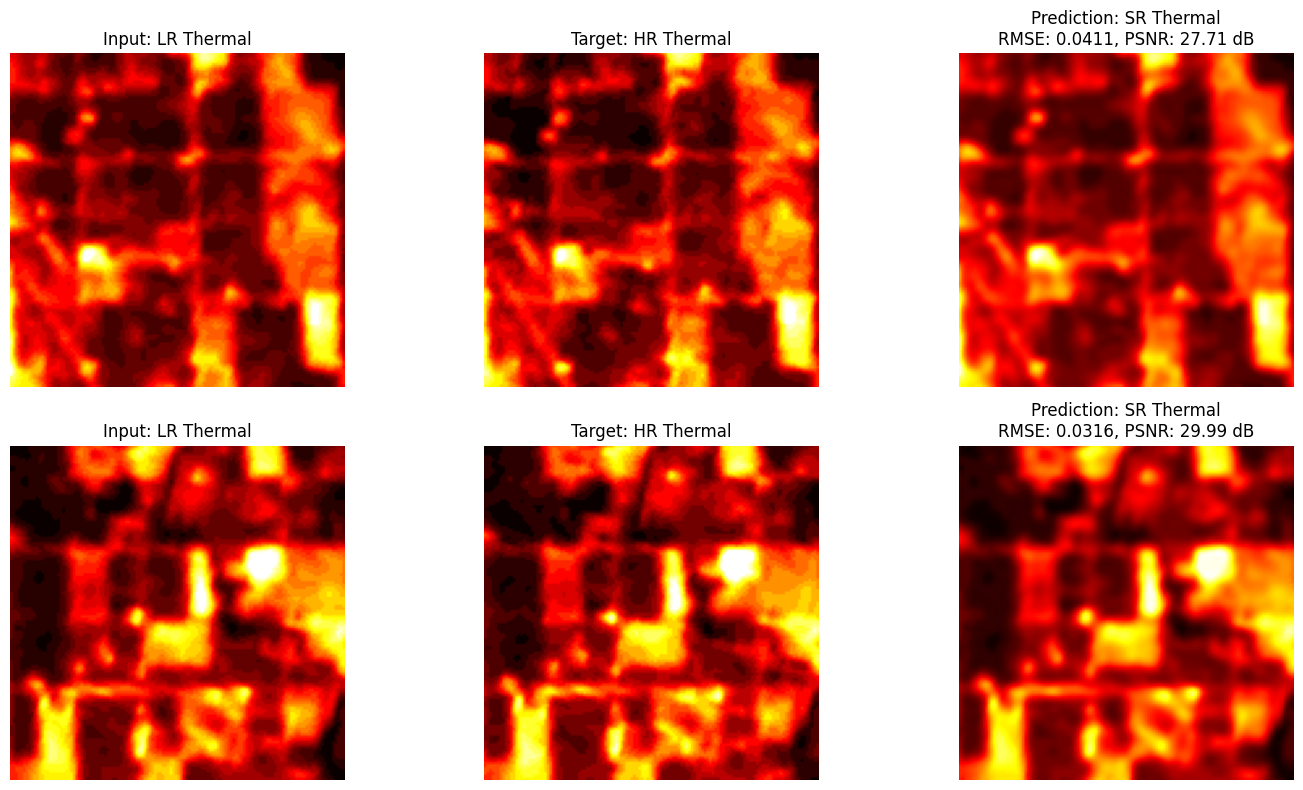

Prediction visualization completed! 🎨


In [13]:
# ========== BLOCK 13: PREDICTION VISUALIZATION ==========
print("Generating prediction visualizations...")

def visualize_predictions(model, dataloader, device, num_samples=2):
    model.eval()
    
    # Get a batch from the test dataloader
    test_batch = next(iter(dataloader))
    inputs = test_batch['input'].to(device)
    targets = test_batch['target'].to(device)
    
    # Make predictions
    with torch.no_grad():
        predictions = model(inputs)
    
    # Convert to numpy for plotting
    inputs_np = inputs.cpu().numpy()
    targets_np = targets.cpu().numpy()
    preds_np = predictions['sr_output'].cpu().numpy()
    
    # Create visualization
    fig, axes = plt.subplots(num_samples, 3, figsize=(15, 4*num_samples))
    
    for i in range(num_samples):
        # Input: Low-resolution thermal (channel 0)
        lr_thermal = inputs_np[i, 0]
        
        # Target: High-resolution thermal (channel 1)
        hr_target = targets_np[i, 0]
        
        # Prediction: Super-resolved thermal
        sr_pred = preds_np[i, 0]
        
        # Calculate metrics for this sample
        rmse = np.sqrt(np.mean((sr_pred - hr_target)**2))
        psnr = 20 * np.log10(1.0 / rmse)
        
        # Plot 1: Input (Low-res Thermal)
        axes[i, 0].imshow(lr_thermal, cmap='hot')
        axes[i, 0].set_title(f'Input: LR Thermal')
        axes[i, 0].axis('off')
        
        # Plot 2: Target (High-res Thermal)
        axes[i, 1].imshow(hr_target, cmap='hot')
        axes[i, 1].set_title('Target: HR Thermal')
        axes[i, 1].axis('off')
        
        # Plot 3: Prediction (Super-resolved Thermal)
        axes[i, 2].imshow(sr_pred, cmap='hot')
        axes[i, 2].set_title(f'Prediction: SR Thermal\nRMSE: {rmse:.4f}, PSNR: {psnr:.2f} dB')
        axes[i, 2].axis('off')
    
    plt.tight_layout()
    plt.show()

# Visualize 2 predictions
print("Visualizing predictions on test data...")
visualize_predictions(
    model=complete_model,
    dataloader=dataloaders['test'],
    device=device,
    num_samples=2
)

print("Prediction visualization completed! 🎨")

In [14]:
# Save only model weights (recommended)
torch.save(complete_model.state_dict(), "/kaggle/working/model_weights.pth")

# Save the full model (includes architecture + weights)
torch.save(complete_model, "/kaggle/working/model_full.pth")

print("✅ Models saved successfully in /kaggle/working/")

✅ Models saved successfully in /kaggle/working/
